In [72]:
import numpy as np
from tqdm import tqdm
import sympy as sp
import matplotlib.pyplot as plt
class brute_calculator:
    def __init__(self, lx, hx, lz, hz):
        self.lz = lz
        self.hz = hz
        self.lx = lx
        self.hx = hx
        self.syndrome_dictionary = {} #key: syndrome, value: [weight I class, weight LZ class, weight LX class, weight LY class]
        self.error_loop()
        
    def error_loop(self):
        n = len(self.lz[0])
        print(n)
        pX = sp.symbols('pX')
        pZ = sp.symbols('pZ')
        pY = sp.symbols('pY')
        pI = 1-pX-pY-pZ
        #loop over all errors
        for i in tqdm(range(2**n)):
            for j in range(2**n):

                errorx = np.array([int(x) for x in bin(i)[2:].zfill(n)])
                errorz = np.array([int(x) for x in bin(j)[2:].zfill(n)])
                ey = errorx*errorz
                hamming_weight_x_errors = np.sum((ey+errorx)%2)
                hamming_weight_z_errors = np.sum((ey+errorz)%2)
                hamming_weight_y_errors = np.sum(ey)

                ham_sum = hamming_weight_x_errors + hamming_weight_z_errors + hamming_weight_y_errors
                error_probability = pI**(n-ham_sum)*pX**hamming_weight_x_errors*pZ**hamming_weight_z_errors*pY**hamming_weight_y_errors
                syndrome = []
                if len(self.hz)>0:
                    syndrome.append(((self.hz@errorx)%2).astype(int))
                if len(self.hx)>0:
                    syndrome.append(((self.hx@errorz)%2).astype(int))
                #syndrome = np.append((self.hz@errorx)%2, (self.hx@errorz)%2)
                print(syndrome)
                syndrome = syndrome[0]
                syndrome_string = np.array2string(syndrome)
                error_class_x = int((self.lz[0]@errorx)%2)
                error_class_z = int((self.lx[0]@errorz)%2)
                error_class = error_class_x*2+ error_class_z
                print(syndrome, error_probability)
                if syndrome_string in self.syndrome_dictionary:
                    self.syndrome_dictionary[syndrome_string][error_class] += error_probability
                else:
                    self.syndrome_dictionary[syndrome_string] = [0,0,0,0]
                    self.syndrome_dictionary[syndrome_string][error_class] += error_probability
    
    


In [73]:
def repetition_code(m):
    lx = [np.ones(m)]
    lz = [np.zeros(m)]
    lz[0][0]=1
    hx =[]
    hz =[]
    for i in range(1,m):
        hzi=np.zeros(m)
        hzi[0]=1
        hzi[i]=1
        hz.append(hzi)
    return  np.array(lx),np.array(hx),np.array(lz),np.array(hz)



In [81]:
def entropy(p):
    e = 0
    for pi in p:
        if pi !=0:
            e =e-pi*np.log2(pi)
    return e

def rate(p):
    pI = p[0]
    pX = p[1]
    pY = p[2]
    pZ = p[3]
    return 1+pI*np.log2(pI)+pX*np.log2(pX)+pY*np.log2(pY)+pZ*np.log2(pZ)

def compute_rate(n,k, syndrome_dict, px, py, pz):
    rate_output=0
    pX = sp.symbols('pX')
    pZ = sp.symbols('pZ')
    pY = sp.symbols('pY')
    
    for s in range(2**(n-k)):
        syndrome = np.array([int(x) for x in bin(s)[2:].zfill(n-k)])
        syndrome_string = np.array2string(syndrome)
        prob_dist =[]
        for logical_class in syndrome_dict[syndrome_string]:
            prob_dist.append(logical_class.evalf(subs={pX:px,pY:py,pZ:pz}))
        p_s =  float(sum(prob_dist))
        pmf = [float(p_l/p_s) for p_l in prob_dist]
        e = entropy(pmf)
        #rate += max(p_s*(1-e),0)
        rate_output += p_s*rate(pmf)
    rate_output = rate_output/n
    return rate_output


In [82]:
def get_best_rate(pX,pY,pZ,synddicts,max_num_repetitions):
    pvec = [1-pX-pY-pZ,pX,pY,pZ]
    best_rate = rate(pvec)
    best_number_of_repetitions = 1
    for repetitions in range(2,max_num_repetitions):
        r = compute_rate(repetitions,1, synddicts[repetitions], pX, pY, pZ)
        if r>=best_rate:
            best_rate = r
            best_number_of_repetitions = repetitions
    print(pX+pY+pZ,best_rate,best_number_of_repetitions)
    return best_rate

In [83]:
max_num_repetitions = 3
synddicts = dict()
for r in range(2,max_num_repetitions):
    lx, hx, lz, hz = repetition_code(r)
    synddict = brute_calculator(lx, hx, lz, hz).syndrome_dictionary
    synddicts[r] = synddict

2


100%|██████████| 4/4 [00:00<00:00, 220.01it/s]

[array([0])]
[0] (-pX - pY - pZ + 1)**2
[array([0])]
[0] pZ*(-pX - pY - pZ + 1)
[array([0])]
[0] pZ*(-pX - pY - pZ + 1)
[array([0])]
[0] pZ**2
[array([1])]
[1] pX*(-pX - pY - pZ + 1)
[array([1])]
[1] pY*(-pX - pY - pZ + 1)
[array([1])]
[1] pX*pZ
[array([1])]
[1] pY*pZ
[array([1])]
[1] pX*(-pX - pY - pZ + 1)
[array([1])]
[1] pX*pZ
[array([1])]
[1] pY*(-pX - pY - pZ + 1)
[array([1])]
[1] pY*pZ
[array([0])]
[0] pX**2
[array([0])]
[0] pX*pY
[array([0])]
[0] pX*pY
[array([0])]
[0] pY**2


In [84]:
synddicts

{2: {'[0]': [pZ**2 + (-pX - pY - pZ + 1)**2,
   2*pZ*(-pX - pY - pZ + 1),
   pX**2 + pY**2,
   2*pX*pY],
  '[1]': [pX*(-pX - pY - pZ + 1) + pY*pZ,
   pX*pZ + pY*(-pX - pY - pZ + 1),
   pX*(-pX - pY - pZ + 1) + pY*pZ,
   pX*pZ + pY*(-pX - pY - pZ + 1)]}}

0.2299999999999998 0.09506470943553097 1
0.23100000000000007 0.09272289279250984 1
0.23199999999999996 0.0903889188427709 1
0.2330000000000004 0.08806276475402713 1
0.23400000000000015 0.08574440792883115 1
0.23500000000000038 0.0834338260016726 1
0.23599999999999977 0.08113099683614527 1
0.23700000000000004 0.07883589852214273 1
0.23800000000000018 0.07654850937312507 1
0.2389999999999999 0.074268807923412 1
0.2399999999999997 0.07199677292553075 1
0.24099999999999963 0.06973238334761128 1
0.242 0.06747561837082133 1
0.2430000000000005 0.06522645738684751 1
0.24399999999999983 0.06298487999541896 1
0.24499999999999947 0.060750866001862414 1
0.24599999999999966 0.05852439541471488 1
0.24700000000000016 0.05630544844336577 1
0.24800000000000022 0.054094005495741004 1
0.24900000000000008 0.05189004717601936 1
0.25000000000000017 0.04969355428239408 1
0.2509999999999998 0.0475045078048702 1
0.2519999999999997 0.04532288892309 1
0.25300000000000045 0.043148679004203716 1
0.2539999999999998

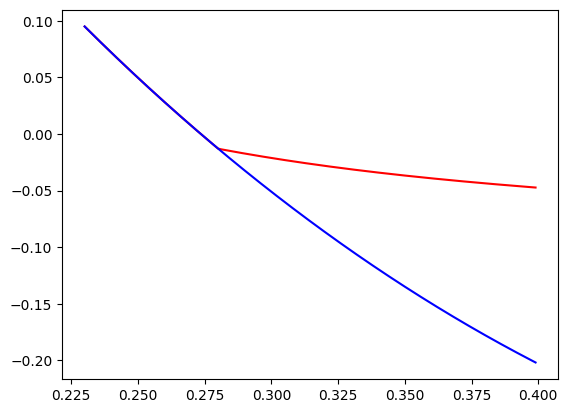

In [87]:
concatenated_best_rate = []
hashing_rate = []
prange =np.arange(0.23,0.4,0.001)

for p_total in prange:
    if (10-np.sqrt(100-36*p_total) >=0) and (10-np.sqrt(100-36*p_total)<=1):
        q = (10-np.sqrt(100-36*p_total))/18
    else:
        q = (10+np.sqrt(100-36*p_total))/18
    qx = q
    qz = 9*q
    pX = qx*(1-qz)
    pZ = qz*(1-qx)
    pY = qx*qz
#    pX = 0.25/3
#    pY= 0.25/3
#    pZ = 0.25/3
    
    pvec = [1-pX-pY-pZ,pX,pY,pZ]
    hashing_rate.append(rate(pvec))
    concatenated_best_rate.append(get_best_rate(pX,pY,pZ,synddicts,max_num_repetitions))
plt.plot(prange,concatenated_best_rate,'r')
plt.plot(prange,hashing_rate,'b')